In [1]:
# Library imports
import geopandas as gpd
import osmnx as ox
import networkx as nx
import momepy
import matplotlib.pyplot as plt
import folium
import pandas as pd

C:\Users\b8008458\AppData\Local\Temp\ipykernel_21984\2182633286.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# set location
place = "Newcastle Upon Tyne, United Kingdom"

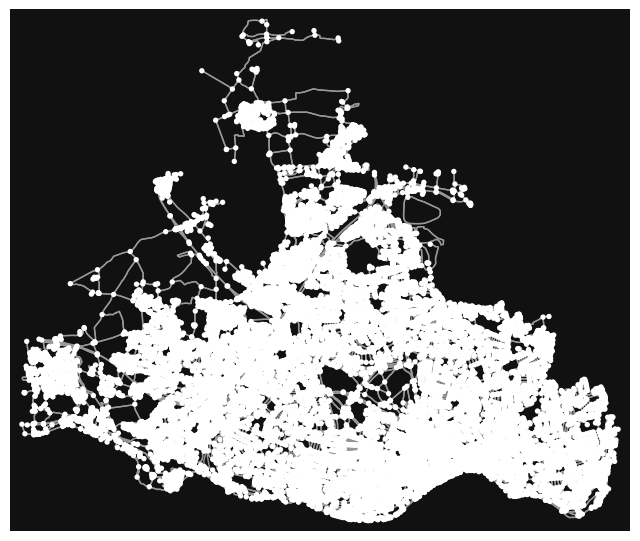

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
# obtain street network and plot
g = ox.graph_from_place(place, network_type='all')
ox.plot_graph(ox.project_graph(g))

In [4]:
# convert to a gdf
gdf = ox.graph_to_gdfs(g, nodes=False, edges=True)
gdf_nodes = ox.graph_to_gdfs(g, nodes=True, edges=False)

In [5]:
# set crs
gdf = gdf.to_crs(3857)
gdf_nodes = gdf_nodes.to_crs(3857)

In [7]:
# Find "neighbourhood" roads
neighbourhoods = gdf.loc[~((gdf['highway'] == 'trunk') |
                        (gdf['highway'] == 'trunk_link') |
                        (gdf['highway'] == 'motorway') |
                        (gdf['highway'] == 'motorway_link') |
                        (gdf['highway'] == 'primary') |
                        (gdf['highway'] == 'primary_link') |
                        (gdf['highway'] == 'secondary') |
                        (gdf['highway'] == 'secondary_link') |
                        (gdf['highway'] == 'tertiary') |
                        (gdf['highway'] == 'tertiary_link') |
                        # speeds
                        (gdf['maxspeed'] == '60 mph') | 
                        (gdf['maxspeed'] == '70 mph') |
                        (gdf['maxspeed'] == '40 mph') |
                        (gdf['maxspeed'] == '30 mph') |
                        (gdf['maxspeed'] == ('20 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('40 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('60 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('50 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('20 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '70 mph')) |
                        # combined queries
                        ((gdf['highway'] == 'residential') & (gdf['maxspeed'] != '30 mph'))
                        )]

In [8]:
# Find "boundary" roads
boundary_roads = gdf.loc[((gdf['highway'] == 'trunk') |
                        (gdf['highway'] == 'trunk_link') |
                        (gdf['highway'] == 'motorway') |
                        (gdf['highway'] == 'motorway_link') |
                        (gdf['highway'] == 'primary') |
                        (gdf['highway'] == 'primary_link') |
                        (gdf['highway'] == 'secondary') |
                        (gdf['highway'] == 'secondary_link') |
                        (gdf['highway'] == 'tertiary') |
                        (gdf['highway'] == 'tertiary_link') |
                        # speeds
                        (gdf['maxspeed'] == '60 mph') | 
                        (gdf['maxspeed'] == '70 mph') |
                        (gdf['maxspeed'] == '40 mph') |
                        (gdf['maxspeed'] == ('20 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('40 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('60 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('50 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('20 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '70 mph')) |
                        # combined queries
                        ((gdf['highway'] == 'residential') & (gdf['maxspeed'] == '30 mph'))
                        )]

In [12]:
boundary_roads.explore()

In [10]:
# create a tiny buffer around the boundary roads
boundary_roads_buffer = boundary_roads.buffer(1)

# reset buffer geoSeries to a geoDataFrame
boundary_roads_buffer_gdf = gpd.GeoDataFrame(gpd.GeoSeries(boundary_roads_buffer))
boundary_roads_buffer_gdf = boundary_roads_buffer_gdf.rename(columns={0:'geometry'}).set_geometry('geometry')

In [ ]:
# cut the full network be the boundary roads
clipped = gpd.overlay(gdf,boundary_roads_buffer_gdf, how='difference')

In [ ]:
clipped

In [ ]:
# convert back to a graph
clipped_g = ox.graph_from_gdfs(gdf_nodes, gdf)

# plot 
ox.plot_graph(clipped_g)

In [ ]:
## Find disconnected components
# convert to a undirected graph
undir_g = clipped_g.to_undirected()

disconnected_components = list(nx.connected_components(undir_g))

# Print disconnected components
for i, component in enumerate(disconnected_components):
    print(f"Disconnected Component {i+1}: {component}")

In [ ]:
for i, component in enumerate(disconnected_components):
    subgraph = undir_g.subgraph(component)
    color = plt.cm.viridis(i / len(disconnected_components))  # Adjust color scale based on component index
    ox.plot_graph(subgraph, node_color='lightgray', edge_color=color, edge_linewidth=1.5, show=False)


In [ ]:
isolated_edges

In [ ]:
# Convert the lists in 'maxspeed' column to tuples
gdf['highway'] = gdf['highway'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Find all unique values in the 'maxspeed' column
unique_maxspeed_values = gdf['highway'].unique()

# Print the unique values
print(unique_maxspeed_values)
